In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
from pathlib import Path

sns.set_theme(style="ticks")
BASE_DIR=Path('/home/brabier/github/gateways-benchmark/federation-v1/scenarios/constant-vus-over-time')

In [27]:
GATEWAY_MAPPING = {
    'grafbase': 'Grafbase Gateway old',
    'grafbase-latest': 'Grafbase Gateway',
    'cosmo': 'Cosmo Router',
    'cosmo2': 'Cosmo2',
    'apollo-router': 'Apollo Router with traffic shaping',
    'apollo-router-no-ts': "Apollo Router",
    'apollo-router2': 'apollo-router2',
    'apollo-router2-ts': 'apollo-router2-ts',
    'mesh-supergraph-bun': 'Mesh'
}

def load_result(path: Path):
    import json
    with open(path / "k6_summary.json") as f:
        data = json.load(f)
    metrics = data['metrics']
    with open(path / "stats.json") as f:
        data = []
        for line in f:
            try:
                data.append(json.loads(line))
            except:
                pass
    mem = max([float(d['MemUsage'].split('MiB')[0]) for d in data if d['MemUsage'] != '--'])
    cpu = max([float(d['CPUPerc'][:-1]) for d in data if d['CPUPerc'] != '--'])

    
    (gateway, vus) = path.name.split('_')
    return {
        'Gateway': GATEWAY_MAPPING[gateway],
        'vus': int(vus),
        'max_ram': mem,
        'max_cpu': cpu,
        'median': metrics['iteration_duration']['values']['med'],
        'p99': metrics['iteration_duration']['values']['p(99)'],
        #'p999': metrics['iteration_duration']['values']['p(99.9)'],
        #'p9999': metrics['iteration_duration']['values']['p(99.99)'],
        #'count': metrics['iterations']['values']['count'],
        'rate': metrics['iterations']['values']['rate'],
    }
    
def load_results(path: Path):
    records = []
    for p in path.glob('*'):
        if not p.name.startswith('grafbase_'):
            try:
                records.append(load_result(p))
            except Exception as e:
                print(p)
                print(e)
    grouped_by_gateway = {}
    for row in records:
        grouped_by_gateway.setdefault(row['Gateway'], []).append(row['vus'])
    for (gateway, vus) in grouped_by_gateway.items():
        print(gateway)
        vus = sorted(vus)
        print(" ".join(map(str, vus)))
    df = pd.DataFrame.from_records(records)
    for k in ['median', 'p99']:
        df[k] = pd.to_timedelta(df[k], unit='ms').astype('timedelta64[us]') / pd.Timedelta(milliseconds=1)
    df = df.set_index(['Gateway', 'vus']).sort_index()
    return df
    
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
RESULTS_DIR = BASE_DIR / '1core-nhost-results'
TITLE_SUFFIX = {
    '1core-nhost-results': "",
    '1core-nd-results': " (10ms subgraph response delay)",
    '2core-nd-results': " (2 CPU cores + 10ms subgraph response delay)",
    '8core-nd-results': ''
}[RESULTS_DIR.name]
IMAGES_DIR = RESULTS_DIR / 'images'
IMAGES_DIR.mkdir(exist_ok=True)
df = load_results(RESULTS_DIR)
df

/home/brabier/github/gateways-benchmark/federation-v1/scenarios/constant-vus-over-time/1core-nhost-results/images
[Errno 2] No such file or directory: '/home/brabier/github/gateways-benchmark/federation-v1/scenarios/constant-vus-over-time/1core-nhost-results/images/k6_summary.json'
/home/brabier/github/gateways-benchmark/federation-v1/scenarios/constant-vus-over-time/1core-nhost-results/grafbase-latest_1400
[Errno 2] No such file or directory: '/home/brabier/github/gateways-benchmark/federation-v1/scenarios/constant-vus-over-time/1core-nhost-results/grafbase-latest_1400/k6_summary.json'
Apollo Router with traffic shaping
100 200 225 250 255 260 265 275 300 325 350 360 365 370 400 500
apollo-router2-ts
100 200 300 350 370
Cosmo Router
100 200 250 300 310 325 350 375 380 400 405 410 425 450 500
apollo-router2
100 200 250 300 310
Mesh
100 150 200 210 220 230 240 245 250 255 260 270 280 290
Apollo Router
100 200 250 300 305 310 315 400
Grafbase Gateway
100 200 300 400 500 600 700 800 900 1

max_ram  max_cpu  median     p99  \
Gateway                            vus                                      
Apollo Router                      100     62.51    35.24   3.410   3.877   
                                   200     63.10    68.18   3.444   3.901   
                                   250     63.31    84.48   3.380   4.153   
                                   300     62.85    99.01   3.544  10.132   
                                   305     63.42    99.36   3.791  10.896   
                                   310     64.48   100.09   4.369  11.739   
                                   315     62.94   100.22   5.096  11.688   
                                   400     74.80   102.58  27.333  41.122   
Apollo Router with traffic shaping 100     59.15    38.88   3.676   4.317   
                                   200     62.29    74.14   3.726   4.049   
                                   225     60.61    85.00   3.706   4.263   
                                   250     64.82    94.05   3.689   7.279   
                                   255     63.38    94.90   3.671   8.379   
                                   260     63.85    96.58   3.760  11.073   
                                   265     65.18    98.47   3.787  13.706   
                                   275     65.79   101.08   4.067  17.206   
                                   300     71.41   102.60   7.878  32.710   
                                   325     72.32   101.70  11.918  37.029   
                                   350     76.62   102.32  18.204  50.535   
                                   360     80.39   101.18  21.705  50.610   
                                   365     78.09   101.84  23.516  53.410   
                                   370     81.18   102.75  26.168  59.178   
                                   400     83.95   101.88  43.869  67.843   
                                   500     90.33   102.62  46.584  68.462   
Cosmo Router                       100     21.10    27.37   3.300   4.576   
                                   200     22.28    54.30   3.291   4.664   
                                   250     23.04    67.51   3.314   5.260   
                                   300     24.21    80.04   3.438   6.283   
                                   310     24.75    83.11   3.518   7.248   
                                   325     26.92    88.92   3.757  27.173   
                                   350     26.23    91.73   4.253  37.912   
                                   375     30.10    96.30   5.244  42.997   
                                   380     33.25    98.50   5.738  45.472   
                                   400     32.30    98.24   6.060  46.307   
                                   405     43.68    99.86   6.393  49.840   
                                   410     46.45    98.85   6.546  53.553   
                                   425     47.77    99.87   8.379  52.438   
                                   450     40.25   100.26  13.519  53.193   
                                   500     49.87   100.34  33.720  56.224   
Cosmo2                             100     19.45    28.55   3.336   4.657   
                                   200     20.93    57.71   3.316   4.700   
                                   300     22.25    83.74   3.528   8.331   
                                   400     34.87    98.02   6.435  49.217   
Grafbase Gateway                   100     10.18     9.87   1.957   2.251   
                                   200     10.11    18.51   1.955   2.275   
                                   300     10.52    28.16   1.964   2.288   
                                   400     11.62    35.73   1.941   2.306   
                                   500     11.95    45.77   1.970   2.448   
                                   600     12.08    54.72   2.013   2.623   
                                   700     12.38    63.77   2.030   2.846   
                                   80

| Gateway                            |   min p99 latency |   Throughput at 150% min p99 latency (req/s) |   Peak throughput |   Peak RAM (MiB) |
|:-----------------------------------|------------------:|---------------------------------------------:|------------------:|-----------------:|
| apollo-router2                     |               3.8 |                               252   (5.8 ms) |    310  (62.0 ms) |               83 |
| Apollo Router                      |               3.9 |                               264   (5.8 ms) |    313  (11.7 ms) |               64 |
| Apollo Router with traffic shaping |               4.0 |                               240   (6.1 ms) |    368  (59.2 ms) |               81 |
| apollo-router2-ts                  |               4.2 |                               206   (6.2 ms) |    369  (50.1 ms) |               78 |
| Cosmo Router                       |               4.6 |                               306   (6.9 ms) |    402  (49.8 ms) |     

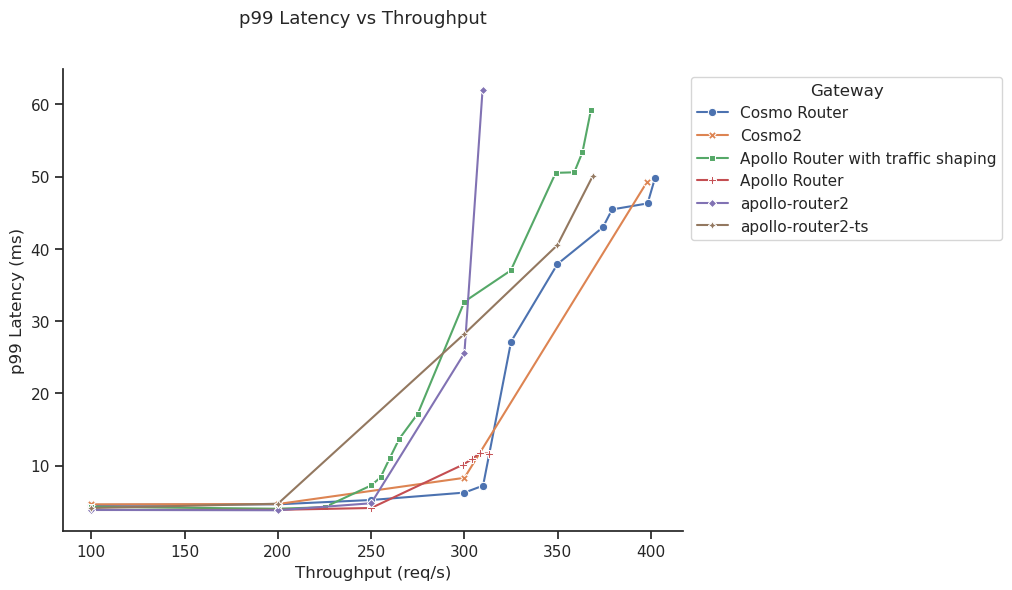

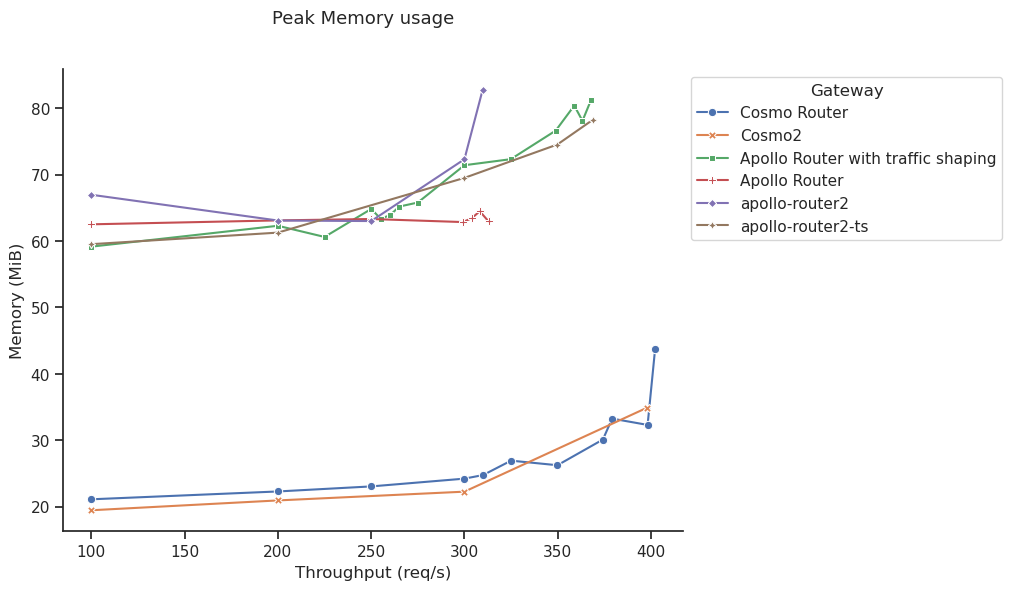

In [29]:
GATEWAY_ORDER = [
    #'Grafbase Gateway', 
    'Cosmo Router', 
    'Cosmo2',
    'Apollo Router with traffic shaping', 
    'Apollo Router', 
    'apollo-router2',
    'apollo-router2-ts',
    #'Mesh'
]
# TITLE_SUFFIX = ""

def plot_custom(df):
    df = df.copy(deep=True)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x="rate", y="p99", sort=True, ax=ax, hue="Gateway", style="Gateway", hue_order=GATEWAY_ORDER, 
                 style_order=GATEWAY_ORDER, dashes=False, data=df, markers=True)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    f.suptitle(f"p99 Latency vs Throughput{TITLE_SUFFIX}", fontsize=13)
    ax.set_xlabel('Throughput (req/s)')
    ax.set_ylabel('p99 Latency (ms)')

    # ax.set_yscale('log')
    # ax.invert_yaxis()
    sns.despine()
    ax.xaxis.set_major_formatter(ScalarFormatter())
    # ax.yaxis.set_major_formatter(ScalarFormatter())

def plot_peak_ram(df):
    df = df.copy(deep=True)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x="rate", y="max_ram", sort=True, ax=ax, style="Gateway", hue="Gateway", 
                 style_order=GATEWAY_ORDER, hue_order=GATEWAY_ORDER, markers=True, data=df, dashes=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    f.suptitle(f"Peak Memory usage{TITLE_SUFFIX}", fontsize=13)
    ax.set_xlabel('Throughput (req/s)')
    ax.set_ylabel('Memory (MiB)')
    
    # ax.set_xscale('log')
    sns.despine()
    ax.xaxis.set_major_formatter(ScalarFormatter())

def markdown(df):
    df = df.copy(deep=True)
    df['rate'] = df['rate'].round()
    df['max_ram'] = df['max_ram'].round()

    rows = []
    for gateway in GATEWAY_ORDER:
        df2 = df[df['Gateway'] == gateway].copy(deep=True)
        min_latency = df2['p99'].min()
        x = np.minimum(np.array([1.5, 2, 3]) * min_latency, df2['p99'].max())
        [min_rate, x2_rate, x3_rate] = np.interp(x, df2['p99'], df2['rate'])
        idx = df2['rate'].idxmax()
        rows.append({
            'Gateway': gateway,
            'min p99 latency': min_latency.round(decimals=1),
            'Throughput at 150% min p99 latency (req/s)': fmt_tl(min_rate.round(), x[0].round(decimals=1)), 
            #'200%': "{} ({} ms)".format(int(x2_rate.round()), x[1].round(decimals=1)), 
            #'300%': "{} ({} ms)".format(int(x3_rate.round()), x[2].round(decimals=1)),
            'Peak throughput': fmt_tl(df2['rate'].max(), df2.loc[idx, 'p99'].round(decimals=1)),
            'Peak RAM (MiB)': int(df2['max_ram'].max()),
        })
    print(pd.DataFrame.from_records(rows)
          .sort_values('min p99 latency', ascending=True)
          .to_markdown(index=False, colalign=['left', 'right', 'right', 'right', 'right'], disable_numparse=True))

def fmt_tl(throughput, latency):
    return "{:.0f} {:>10}".format(throughput.round(), "({} ms)".format(latency.round(decimals=1)))

def plot_all(df):
    df = df.copy(deep=True).reset_index()
    df = df[df['Gateway'].isin(GATEWAY_ORDER)]
    # df = df[(df['max_cpu'] < 200)]
    df = df[(df['vus'] - df['rate']).abs() < 3]
    plot_custom(df)
    plt.savefig(IMAGES_DIR / 'latency_vs_throughput.png')
    plot_peak_ram(df)
    plt.savefig(IMAGES_DIR / 'peak_ram.png')
    print(markdown(df))

plot_all(df)

In [62]:
def markdown(df, latency):
    df = df.copy(deep=True)
    df = df[(df['max_cpu'] < CPU_LIMIT) & (df['p99'] < latency)].reset_index()
    idx = df.groupby('Gateway')['rate'].idxmax()
    df['rate'] = df['rate'].round()
    df['max_ram'] = df['max_ram'].round()
    df = df.loc[idx, ['Gateway', 'rate', 'max_ram', 'p99']]
    df = df.rename(columns={
        'rate': 'Rate (req/s)',
        'max_ram': 'Peak RAM (MiB)',
        'p99': 'p99 Latency (ms)'
    })
    print(df.to_markdown(index=False))
    
# markdown(df, 15)
print()
markdown(df, 1500)

NameError: name 'CPU_LIMIT' is not defined

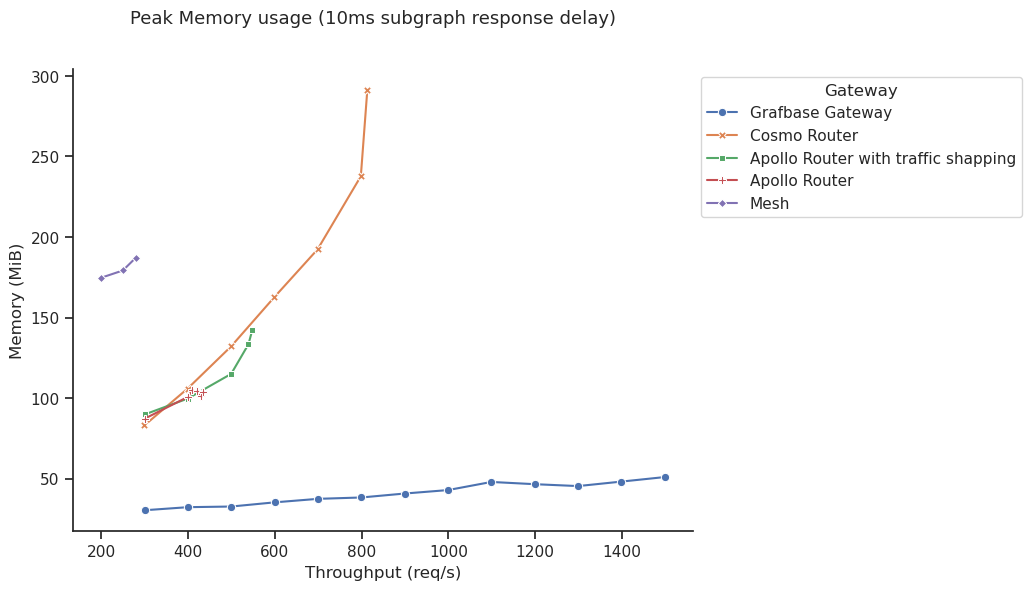

In [8]:
def plot_peak_ram(df):
    df = df.copy(deep=True).reset_index()
    df = df[df['Gateway'].isin(GATEWAY_ORDER)]
    df = df[(df['vus'] - df['rate']).abs() < MAX_RATE_DIFF]
    f, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x="rate", y="max_ram", sort=True, ax=ax, style="Gateway", hue="Gateway", style_order=GATEWAY_ORDER, hue_order=GATEWAY_ORDER, markers=True, data=df, dashes=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    f.suptitle("Peak Memory usage (10ms subgraph response delay)", fontsize=13)
    ax.set_xlabel('Throughput (req/s)')
    ax.set_ylabel('Memory (MiB)')
    
    # ax.set_xscale('log')
    sns.despine()
    ax.xaxis.set_major_formatter(ScalarFormatter())

plot_peak_ram(df)

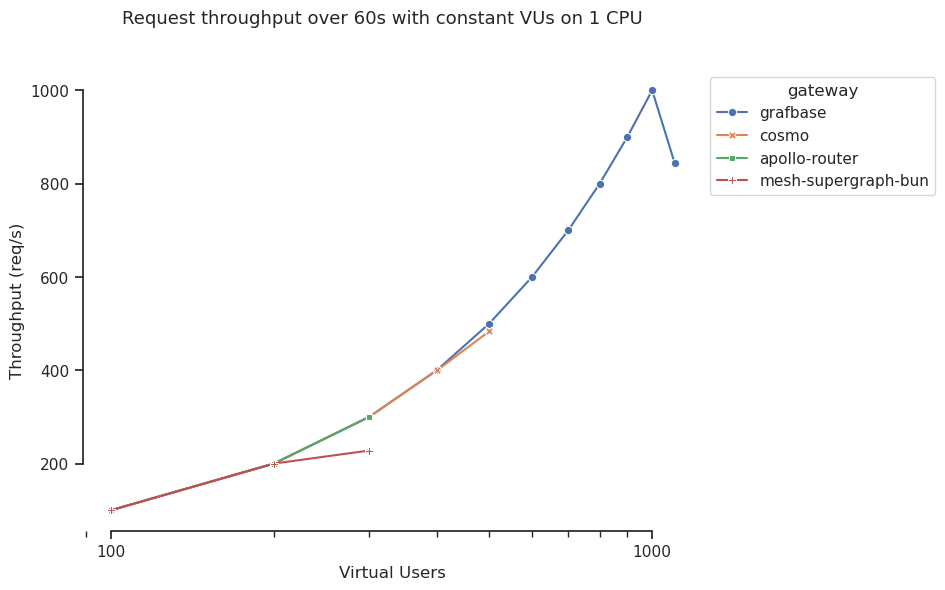

In [8]:
def plot_throughput(df):
    df = df.copy(deep=True)
    
    f, ax = plt.subplots(figsize=(8, 6))
    order = ["grafbase", "cosmo", "apollo-router", "mesh-supergraph-bun"]
    sns.lineplot(x="vus", y="rate", sort=True, ax=ax, style="gateway", hue="gateway", style_order=order, hue_order=order, markers=True, data=df, dashes=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    f.suptitle("Request throughput over 60s with constant VUs on 1 CPU", fontsize=13)
    ax.set_xlabel('Virtual Users')
    ax.set_ylabel('Throughput (req/s)')
    
    ax.set_xscale('log')
    sns.despine(trim=True)
    ax.xaxis.set_major_formatter(ScalarFormatter())

plot_throughput(df)

In [91]:
def csv(df):
    df = df.copy(deep=True)
    df = df[(df['max_cpu'] < 100)].reset_index()
    df['p99'] = (df['p99'] / pd.Timedelta(1, unit='ms')).round(decimals=2)
    df['rate'] = df['rate'].round().astype('int')
    df['max_ram'] = df['max_ram'].round().astype('int')
    print(df[['Gateway', 'rate', 'max_ram','p99']].to_csv(header=True,index=False))
csv(df)

Gateway,rate,max_ram,p99
Apollo Router,100,62,9.02
Apollo Router,200,57,9.23
Apollo Router,250,64,10.64
Apollo Router,275,60,10.01
Apollo Router,300,59,11.5
Apollo Router,305,62,13.92
Apollo Router,310,62,14.68
Apollo Router,320,64,16.82
Apollo Router,324,62,15.9
Cosmo Router,100,20,8.87
Cosmo Router,200,21,9.21
Cosmo Router,250,25,11.2
Cosmo Router,300,23,10.9
Cosmo Router,310,23,11.7
Cosmo Router,320,23,12.1
Cosmo Router,330,32,13.46
Cosmo Router,335,24,14.23
Cosmo Router,340,24,17.2
Cosmo Router,350,25,22.22
Cosmo Router,397,28,37.64
Cosmo Router,443,36,41.94
Cosmo Router,456,39,43.42
Grafbase Gateway,100,11,7.85
Grafbase Gateway,200,11,7.79
Grafbase Gateway,300,12,8.09
Grafbase Gateway,400,12,8.33
Grafbase Gateway,500,12,8.64
Grafbase Gateway,600,12,9.11
Grafbase Gateway,700,12,9.39
Grafbase Gateway,800,14,9.82
Grafbase Gateway,900,14,10.46
Grafbase Gateway,950,15,11.2
Grafbase Gateway,999,18,12.54
Grafbase Gateway,1025,17,14.25
Grafbase Gateway,1029,29,15.07
Grafbase Gateway,1049,

In [53]:
def human_friendly(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True).reset_index()
    df = df[df['vus'] == 1]
    df['max_ram'] = df['max_ram'].round(decimals=0)
    df['rate'] = df['rate'].round(decimals=0)
    for k in ['median', 'p99', 'p999', 'p9999']:
        df[k] = df[k] / pd.Timedelta(milliseconds=1)
    return df
print(human_friendly(df)[['gateway', 'p99', 'p999', 'rate']].to_markdown(index=False))

| gateway             |   p99 |   p999 |   rate |
|:--------------------|------:|-------:|-------:|
| apollo-router       |     9 |      9 |    147 |
| cosmo               |     8 |      9 |    151 |
| grafbase            |     7 |      7 |    188 |
| mesh-supergraph-bun |     9 |     10 |    152 |


In [48]:
def comparison(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    all_vus = [1, 2, 5, 10, 20, 50, 100, 200, 300]
    # df = df[df['vus'].isin(vus)]
    for gateway in ['apollo-router','cosmo', 'mesh-supergraph-bun', 'grafbase']:
        for vus in all_vus:
            for k in ['rate']:
                df.loc[(gateway, vus), k] =  df.loc[('grafbase', vus), k] / df.loc[(gateway, vus), k]
            for k in ['max_ram']:
                df.loc[(gateway, vus), k] =  df.loc[(gateway, vus), k] / df.loc[('grafbase', vus), k] - 1
    df = df.reset_index()
    df = df[df['vus'].isin(all_vus)]
    return df.set_index(["gateway", "vus"])
dfc = comparison(df)
dfc

max_ram                 median  \
gateway             vus                                     
apollo-router       1     3.282609 0 days 00:00:00.006000   
                    2     2.544872 0 days 00:00:00.006000   
                    5     2.172043 0 days 00:00:00.012000   
                    10    2.072398 0 days 00:00:00.023000   
                    20    2.051903 0 days 00:00:00.044000   
                    50    2.160377 0 days 00:00:00.117000   
                    100   4.370748 0 days 00:00:00.240000   
                    200   1.987701 0 days 00:00:00.501000   
                    300   1.405237 0 days 00:00:00.773000   
cosmo               1     0.347826 0 days 00:00:00.006000   
                    2     0.391026 0 days 00:00:00.007000   
                    5     0.440860 0 days 00:00:00.012000   
                    10    0.570136 0 days 00:00:00.020000   
                    20    0.685121 0 days 00:00:00.037000   
                    50    1.297170 0 days 00:00:00.093000   
                    100   4.653061 0 days 00:00:00.189000   
                    200   2.144749 0 days 00:00:00.395000   
                    300   1.986908 0 days 00:00:00.596000   
grafbase            1     0.000000 0 days 00:00:00.005000   
                    2     0.000000 0 days 00:00:00.005000   
                    5     0.000000 0 days 00:00:00.006000   
                    10    0.000000 0 days 00:00:00.010000   
                    20    0.000000 0 days 00:00:00.018000   
                    50    0.000000 0 days 00:00:00.046000   
                    100   0.000000 0 days 00:00:00.097000   
                    200   0.000000 0 days 00:00:00.214000   
                    300   0.000000 0 days 00:00:00.337000   
mesh-supergraph-bun 1    10.362319 0 days 00:00:00.006000   
                    2     9.775641 0 days 00:00:00.006000   
                    5     8.387097 0 days 00:00:00.014000   
                    10    7.294118 0 days 00:00:00.036000   
                    20    5.878893 0 days 00:00:00.076000   
                    50    4.061321 0 days 00:00:00.206000   
                    100   4.649660 0 days 00:00:00.435000   
                    200   2.142857 0 days 00:00:00.830000   
                    300   1.542394 0 days 00:00:01.333000   

                                           p99                   p999  \
gateway             vus                                                 
apollo-router       1   0 days 00:00:00.009000 0 days 00:00:00.009000   
                    2   0 days 00:00:00.009000 0 days 00:00:00.011000   
                    5   0 days 00:00:00.018000 0 days 00:00:00.033000   
                    10  0 days 00:00:00.033000 0 days 00:00:00.045000   
                    20  0 days 00:00:00.063000 0 days 00:00:00.073000   
                    50  0 days 00:00:00.164000 0 days 00:00:00.184000   
                    100 0 days 00:00:00.338000 0 days 00:00:00.381000   
                    200 0 days 00:00:00.700000 0 days 00:00:00.780000   
                    300 0 days 00:00:01.145000 0 days 00:00:01.250000   
cosmo               1   0 days 00:00:00.008000 0 days 00:00:00.009000   
                    2   0 days 00:00:00.010000 0 days 00:00:00.011000   
                    5   0 days 00:00:00.017000 0 days 00:00:00.030000   
                    10  0 days 00:00:00.035000 0 days 00:00:00.043000   
                    20  0 days 00:00:00.057000 0 days 00:00:00.064000   
                    50  0 days 00:00:00.124000 0 days 00:00:00.140000   
                    100 0 days 00:00:00.241000 0 days 00:00:00.260000   
                    200 0 days 00:00:00.526000 0 days 00:00:00.599000   
                    300 0 days 00:00:00.807000 0 days 00:00:01.018000   
grafbase            1   0 days 00:00:00.007000 0 days 00:00:00.007000   
                    2   0 days 00:00:00.008000 0 days 00:00:00.009000   
                    5   0 days 00:00:00.010000 0 days 00:00:00.011000   
                    10  0 day

In [29]:
from scipy import stats
dfc.reset_index().groupby('gateway')['max_ram'].mean()

gateway
apollo-router          3.450050
cosmo                  2.385281
grafbase               1.000000
mesh-supergraph-bun    6.993922
Name: max_ram, dtype: float64

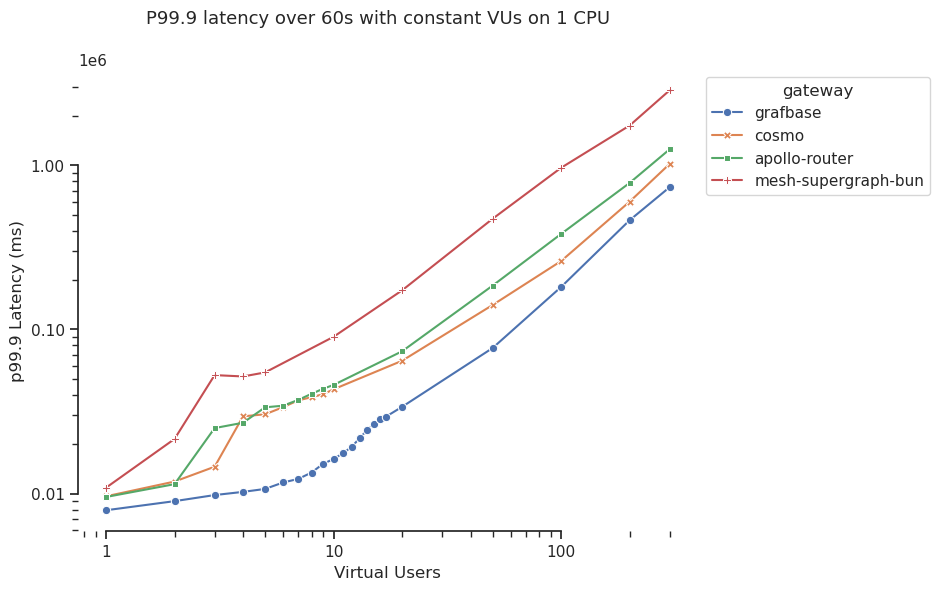

In [135]:
f, ax = plt.subplots(figsize=(8, 6))
order = ["grafbase", "cosmo", "apollo-router", "mesh-supergraph-bun"]
sns.lineplot(x="vus", y="p999", sort=True, ax=ax, style="gateway", hue="gateway", style_order=order, hue_order=order, markers=True, data=df, dashes=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

f.suptitle("P99.9 latency over 60s with constant VUs on 1 CPU", fontsize=13)
ax.set_xlabel('Virtual Users')
ax.set_ylabel('p99.9 Latency (ms)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_yaxis()
sns.despine(trim=True)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

In [48]:
2.3 * 1.5

3.4499999999999997